# Investigating Reasons Some States have Different Results 

Some states have different results in the simulation. We are trying to see what input data might be making this the case. To do that, I am digging into the artifact values used. 

The two specific questions for investigation are: 
1. Why does polypill have an outsized impact on HF DALYs in Kansas and Alabama? 
2. Why does lifestyle do better in HF DALYs in Minnesota and North Carolina?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from vivarium import Artifact
from db_queries import get_population

In [2]:
state_person_time = pd.read_csv('/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/state_person_time.csv')

In [3]:
draws = state_person_time.input_draw.unique()

In [4]:
draws_new = []
for draw in draws: draws_new.append(str('draw_'+ str(draw)))

In [5]:
draws_new

['draw_29',
 'draw_232',
 'draw_357',
 'draw_394',
 'draw_602',
 'draw_629',
 'draw_650',
 'draw_680',
 'draw_829',
 'draw_946']

In [6]:
locations = state_person_time.location.unique()

In [7]:
def convert(word):
    return ' '.join(x.capitalize() or '_' for x in word.split('_'))

location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
location_map.head()

,location_id,location_name,abbreviation
0,102,US,US
1,523,Alabama,AL
2,524,Alaska,AK
3,525,Arizona,AZ
4,526,Arkansas,AR


In [10]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v2-20230721/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[draws_new]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        data = data.groupby(['year_start'])['mean','2.5%','97.5%'].mean().reset_index()
        
        # formatting (may want to format age as well)
        data['location_name'] = convert(i)
        data = data.merge(location_map[['location_name','abbreviation']], on =['location_name'])
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [9]:
def load_artifact_data_paf(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v2-20230721/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[draws_new]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        data = data.groupby(['year_start','affected_entity'])['mean'].mean().reset_index()
        
        # formatting (may want to format age as well)
        data['location_name'] = convert(i)
        data = data.merge(location_map[['location_name','abbreviation']], on =['location_name'])
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [11]:
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v2-20230721/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [12]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'healthcare_entity.outpatient_visits.outpatient_envelope',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction_and_heart_failure.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.heart_failure_from_ischemic_heart_disease.prevalence',
 '

## Start by looking at exposures, so mean and std for SBP, BMI, and FPG

In [69]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art.head()

,year_start,mean,location_name,abbreviation,measure
0,2019,29.079458,Washington,WA,exposure
0,2019,29.197223,Alaska,AK,exposure
0,2019,27.374994,Hawaii,HI,exposure
0,2019,28.353872,Colorado,CO,exposure
0,2019,28.987752,Nevada,NV,exposure


Text(0.5, 1.0, 'BMI Mean by Location')

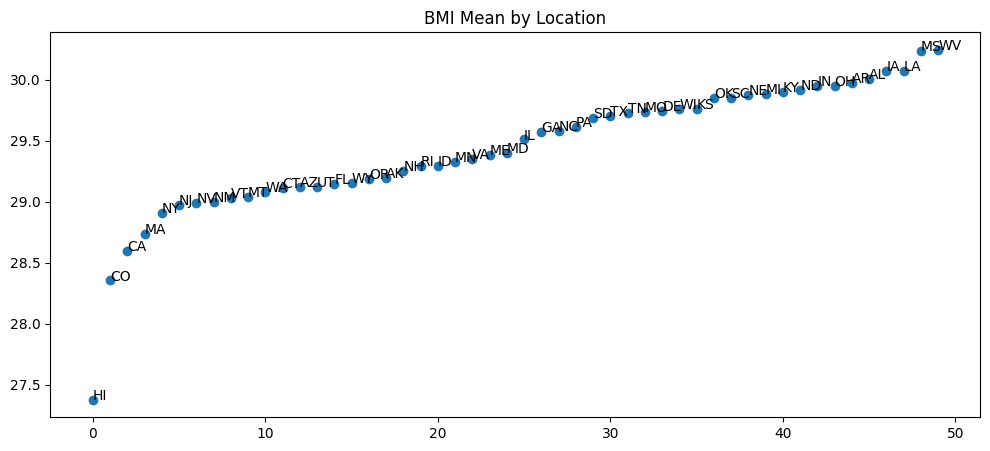

In [75]:
plt.figure(figsize=(12,5))
subdata = bmi_art.sort_values('mean')
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    #if ((subdata.location_name.iloc[i] == 'Minnesota') | (subdata.location_name.iloc[i] == 'North Carolina') | (subdata.location_name.iloc[i] == 'New Hampshire') | (subdata.location_name.iloc[i] == 'Hawaii')):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))

plt.title(f'BMI Mean by Location')

In [12]:
bmi_std = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure_standard_deviation')

Text(0.5, 1.0, 'BMI Standard Deviation by Location')

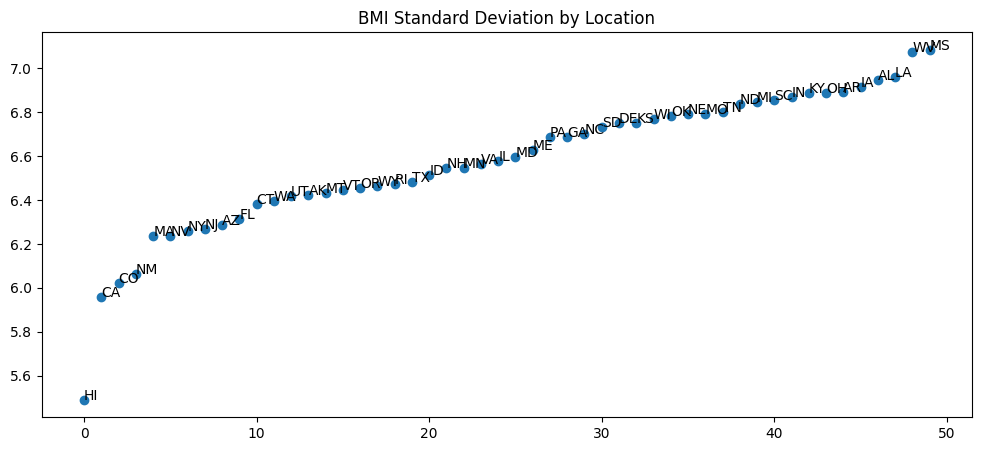

In [13]:
plt.figure(figsize=(12,5))
subdata = bmi_std.sort_values('mean')
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'BMI Standard Deviation by Location')

In [14]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')

Text(0.5, 1.0, 'FPG Mean by Location')

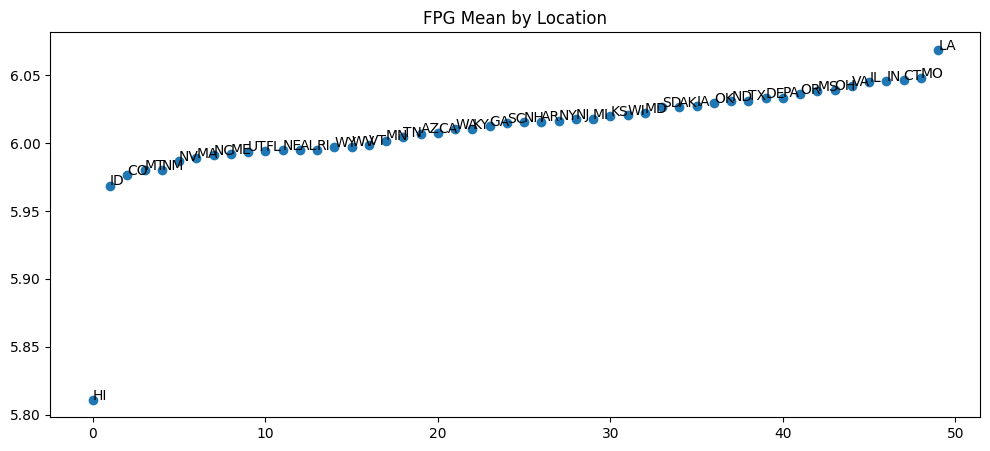

In [15]:
plt.figure(figsize=(12,5))
subdata = fpg_art.sort_values('mean')#.loc[(fpg_art.sex == sex) & (fpg_art.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'FPG Mean by Location')

In [16]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')

Text(0.5, 1.0, 'SBP Mean by Location')

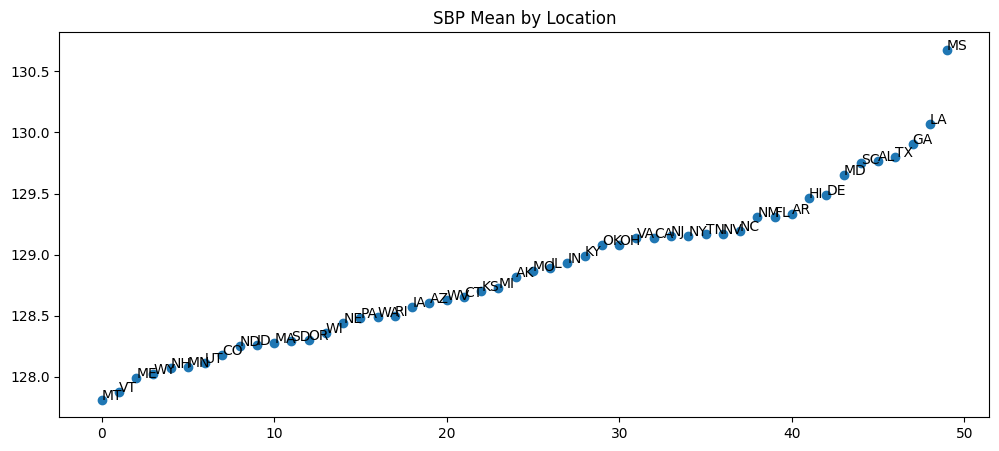

In [17]:
plt.figure(figsize=(12,5))
subdata = sbp_art.sort_values('mean')#.loc[(sbp_art.sex == sex) & (sbp_art.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'SBP Mean by Location')

In [18]:
sbp_std = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure_standard_deviation')

Text(0.5, 1.0, 'SBP Standard Deviation by Location')

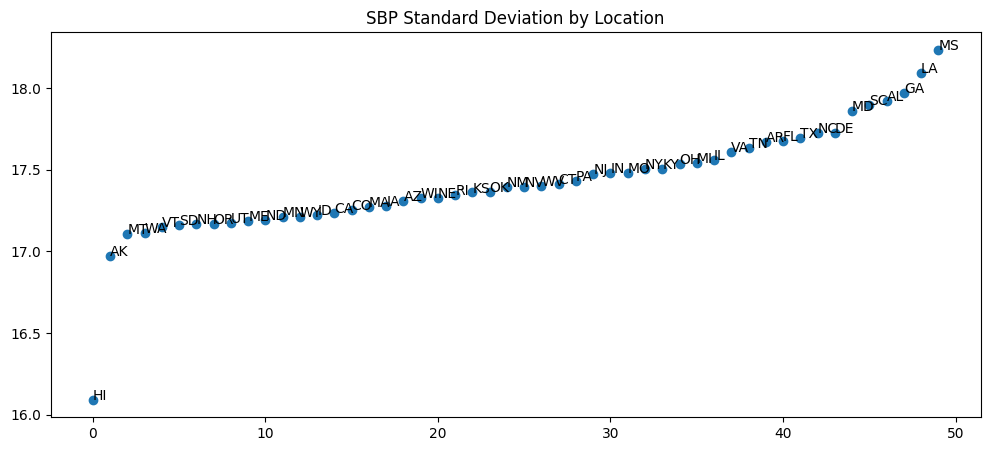

In [19]:
plt.figure(figsize=(12,5))
subdata = sbp_std.sort_values('mean')#.loc[(sbp_std.sex == sex) & (sbp_std.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'SBP Standard Deviation by Location')

In [45]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')

Text(0.5, 1.0, 'LDL-C Mean by Location')

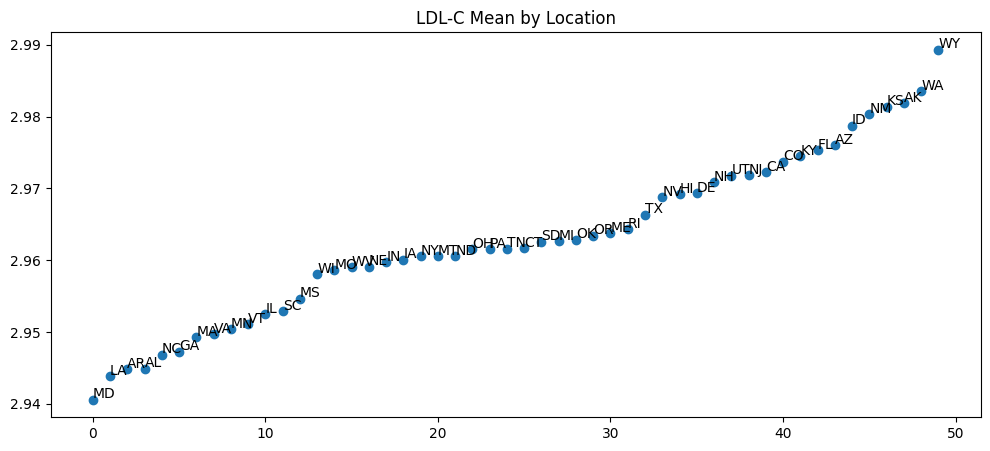

In [46]:
plt.figure(figsize=(12,5))
subdata = ldl_art.sort_values('mean')#.loc[(sbp_art.sex == sex) & (sbp_art.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'LDL-C Mean by Location')

## Next we will check the RR and PAF values 

In [20]:
bmi_rr = load_artifact_data_paf('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')

In [21]:
bmi_rr = bmi_rr.loc[bmi_rr.affected_entity.isin(['heart_failure_from_ischemic_heart_disease', 'heart_failure_residual'])]

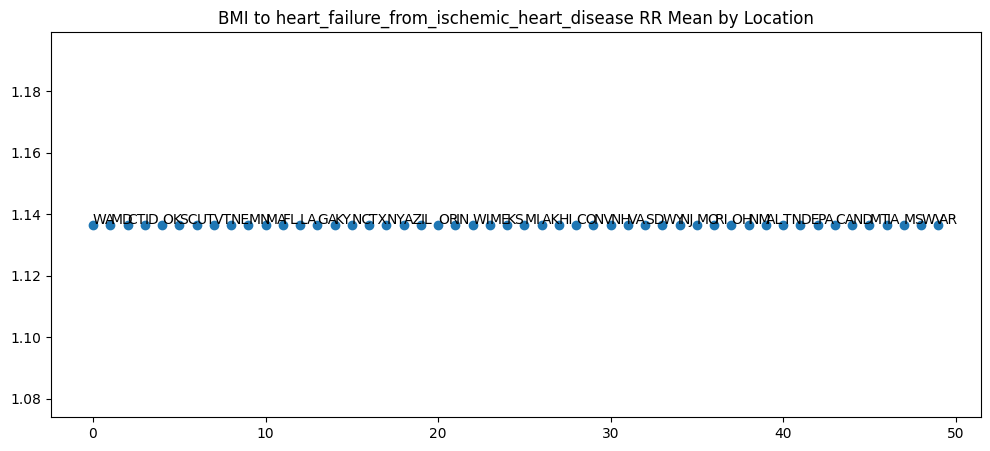

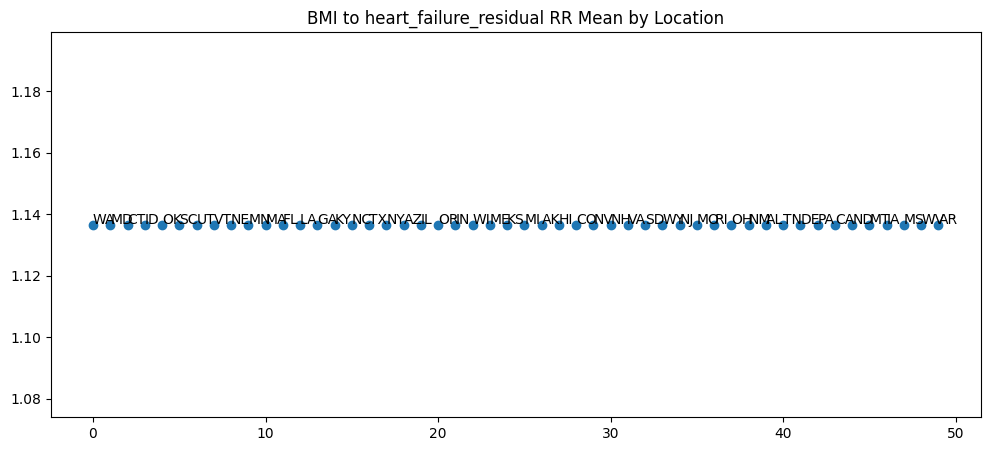

In [22]:
for cause in bmi_rr.affected_entity.unique():
    plt.figure(figsize=(12,5))
    subdata = bmi_rr.loc[(bmi_rr.affected_entity == cause)].sort_values('mean')
    plt.scatter(range(50), subdata['mean'])
    for i in range(50):
        plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
    plt.title(f'BMI to {cause} RR Mean by Location')

Duh, the mean is the same for RR values because there isn't state level variaiton... 
Since HF is the outcome for everything here, we're done with this one. 

In [13]:
bmi_paf = load_artifact_data_paf('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')

In [24]:
#bmi_paf = bmi_paf.loc[bmi_paf.affected_entity.isin(['heart_failure_from_ischemic_heart_disease', 'heart_failure_residual'])]

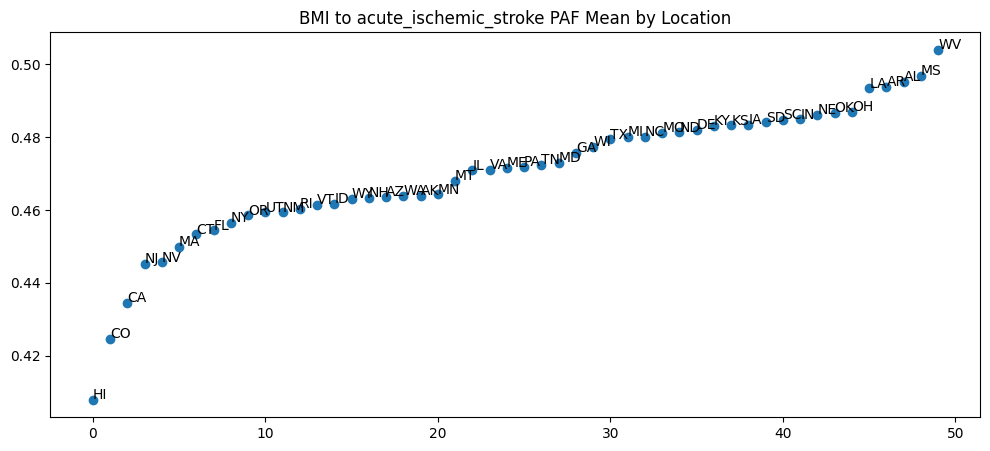

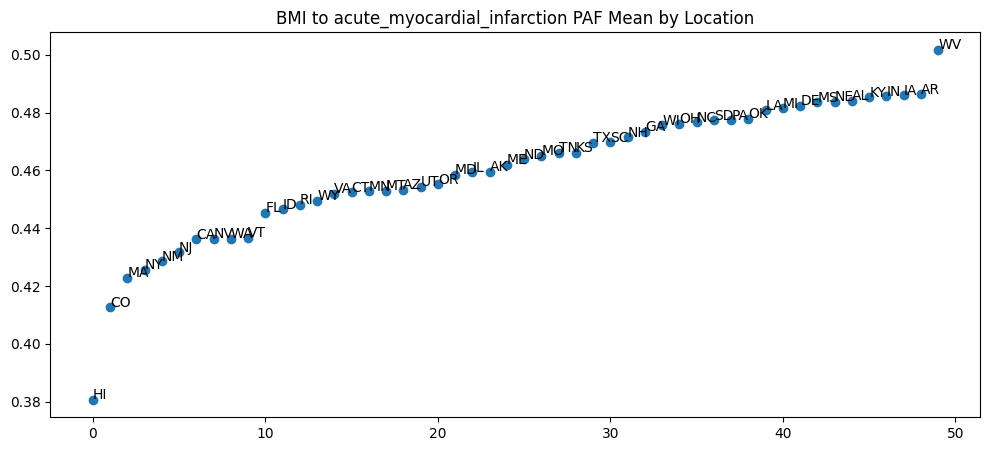

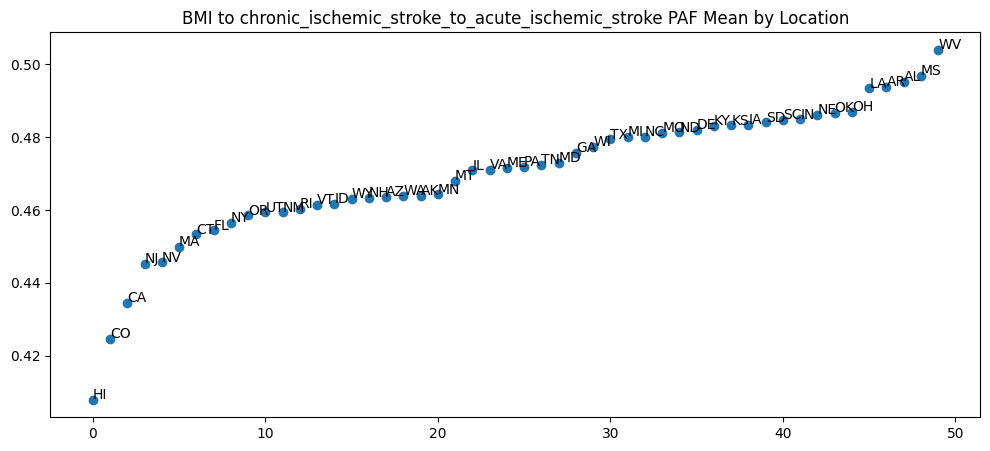

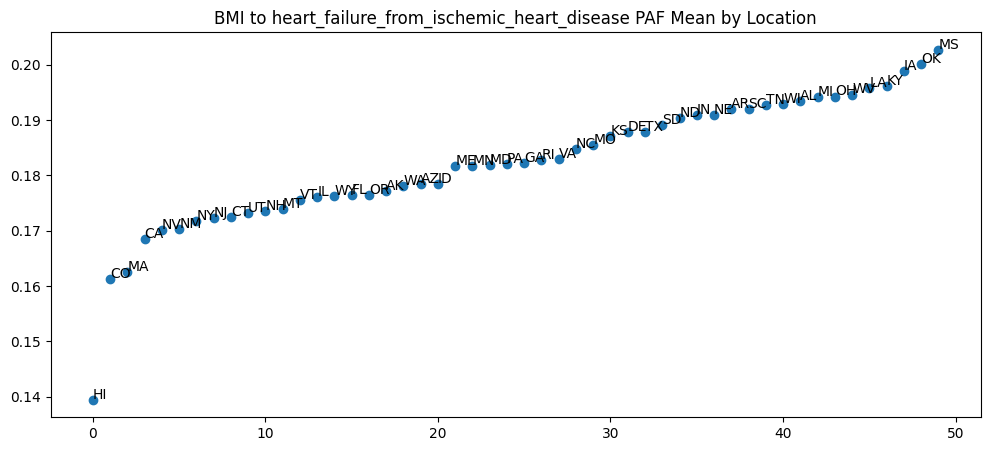

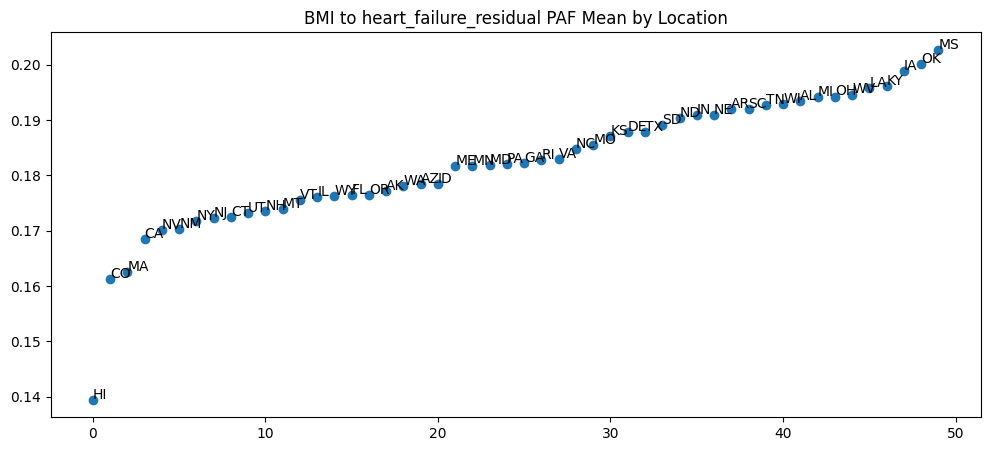

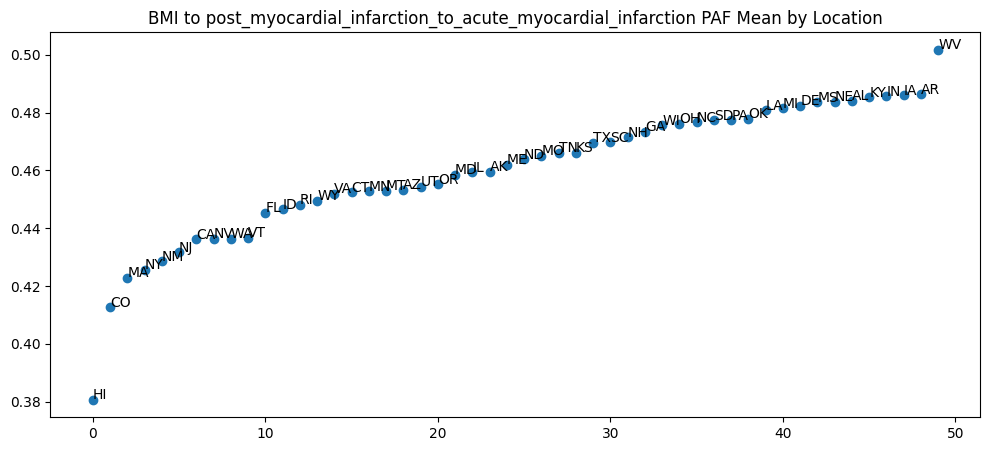

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('bmi_pafs_location.pdf') as pdf:
    for cause in bmi_paf.affected_entity.unique():
        plt.figure(figsize=(12,5))
        subdata = bmi_paf.loc[(bmi_paf.affected_entity == cause)].sort_values('mean')
        plt.scatter(range(50), subdata['mean'])
        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
        plt.title(f'BMI to {cause} PAF Mean by Location')
        pdf.savefig(bbox_inches='tight')

In [15]:
sbp_paf = load_artifact_data_paf('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')

In [27]:
#sbp_paf = sbp_paf.loc[sbp_paf.affected_entity.isin(['heart_failure_from_ischemic_heart_disease', 'heart_failure_residual'])]

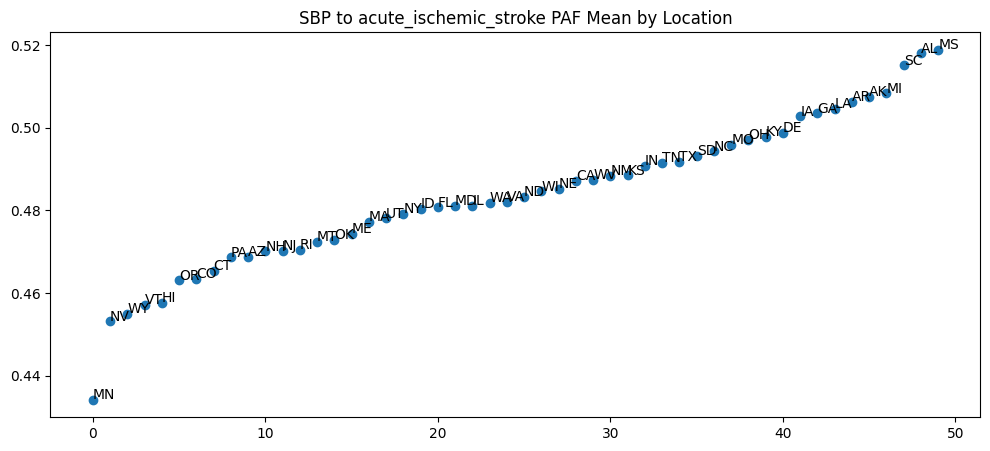

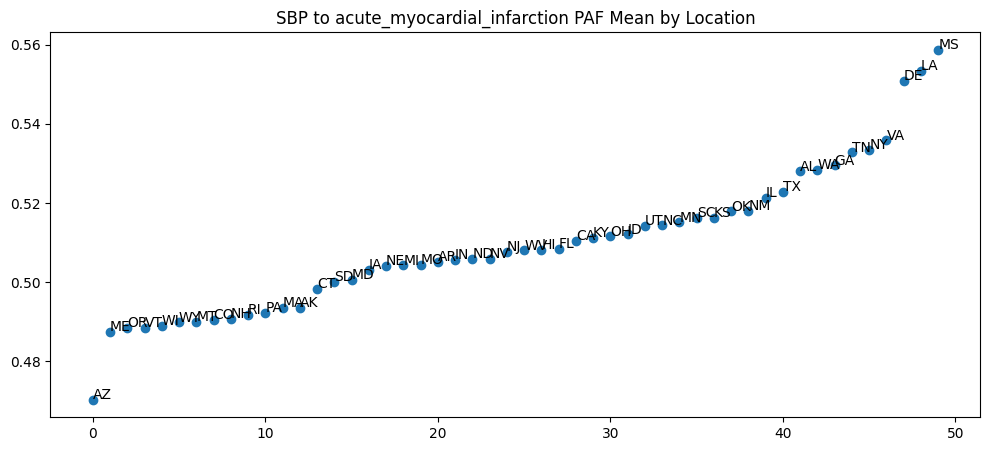

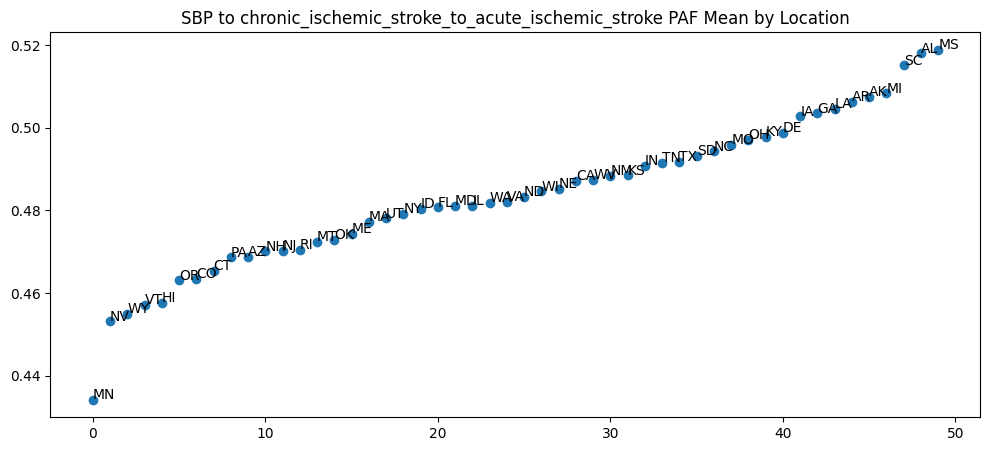

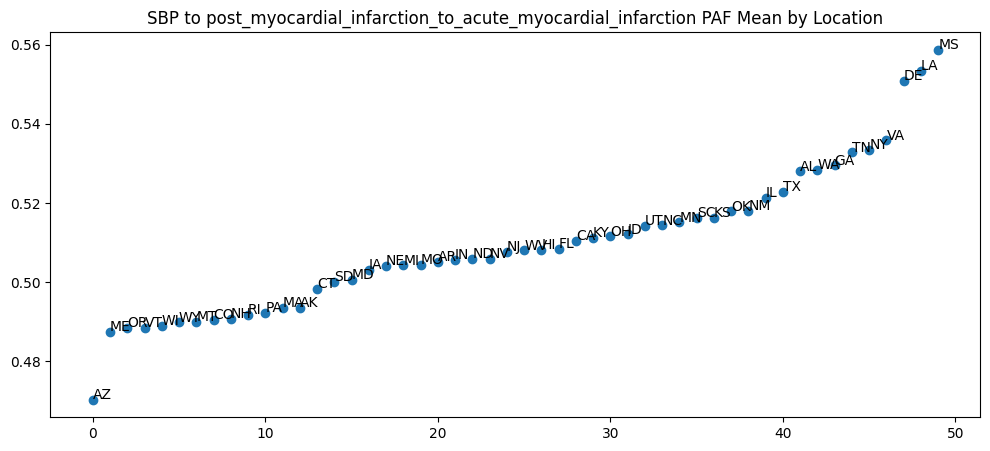

In [16]:
with PdfPages('sbp_pafs_location.pdf') as pdf:
    for cause in sbp_paf.affected_entity.unique():
        plt.figure(figsize=(12,5))
        subdata = sbp_paf.loc[(sbp_paf.affected_entity == cause)].sort_values('mean')
        plt.scatter(range(50), subdata['mean'])
        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
        plt.title(f'SBP to {cause} PAF Mean by Location')
        pdf.savefig(bbox_inches='tight')

In [17]:
fpg_paf = load_artifact_data_paf('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')

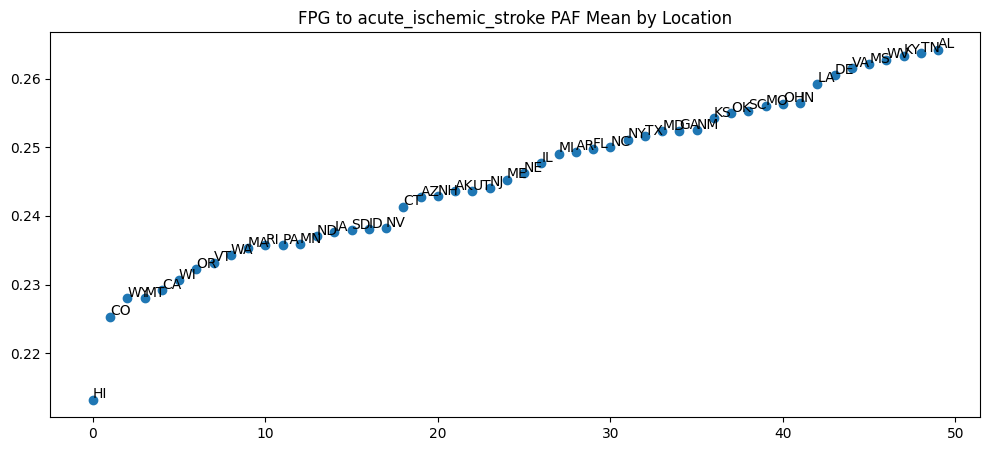

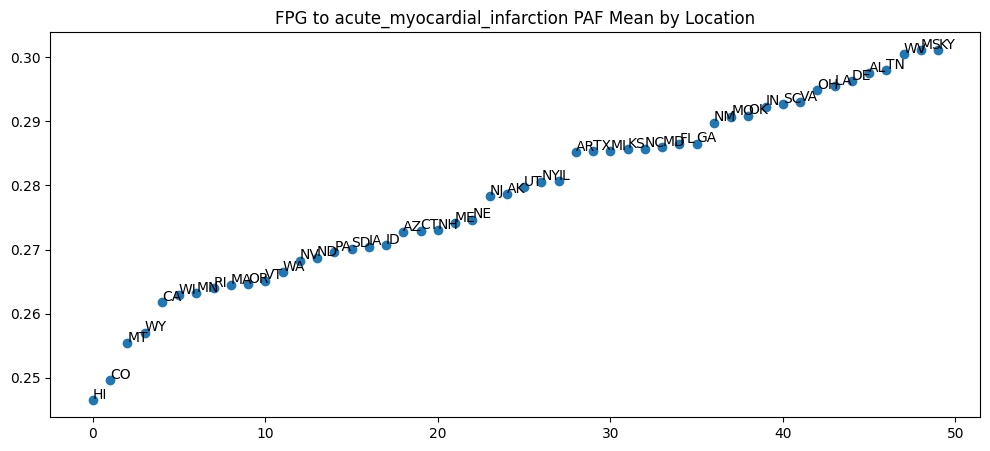

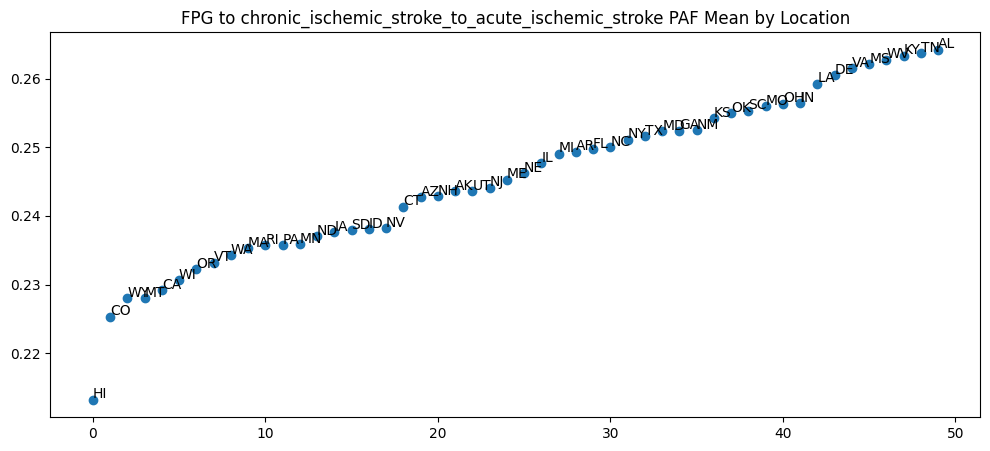

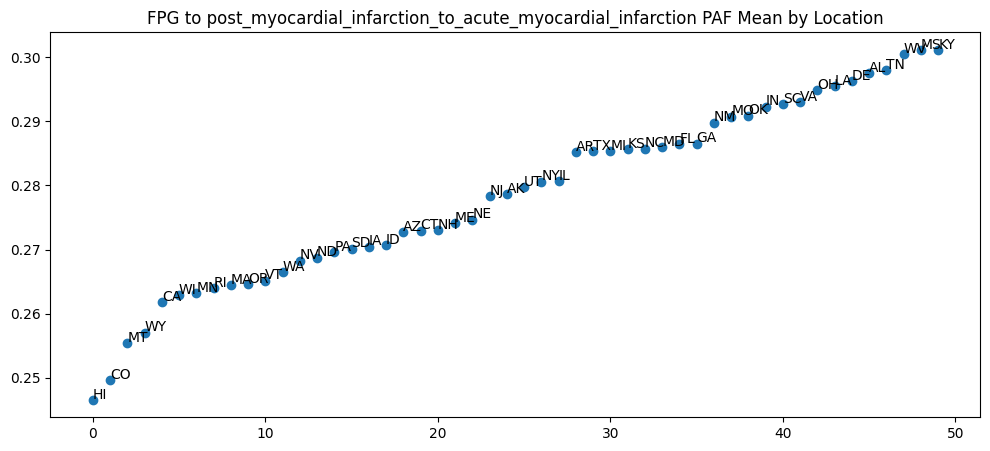

In [18]:
with PdfPages('fpg_pafs_location.pdf') as pdf:
    for cause in fpg_paf.affected_entity.unique():
        plt.figure(figsize=(12,5))
        subdata = fpg_paf.loc[(fpg_paf.affected_entity == cause)].sort_values('mean')
        plt.scatter(range(50), subdata['mean'])
        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
        plt.title(f'FPG to {cause} PAF Mean by Location')
        pdf.savefig(bbox_inches='tight')

In [19]:
ldl_paf = load_artifact_data_paf('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')

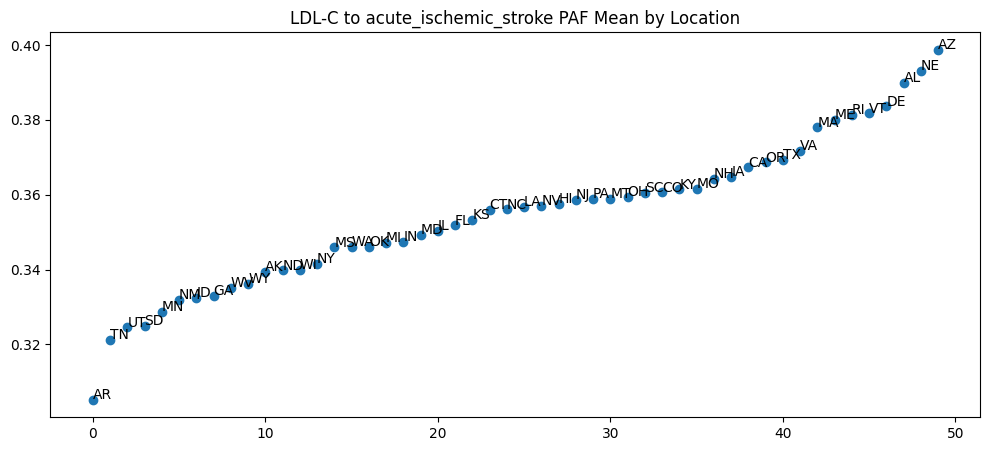

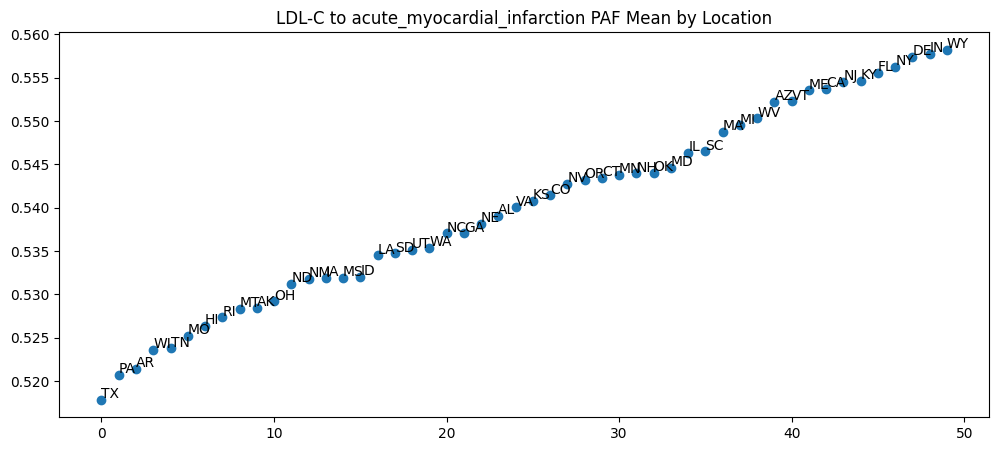

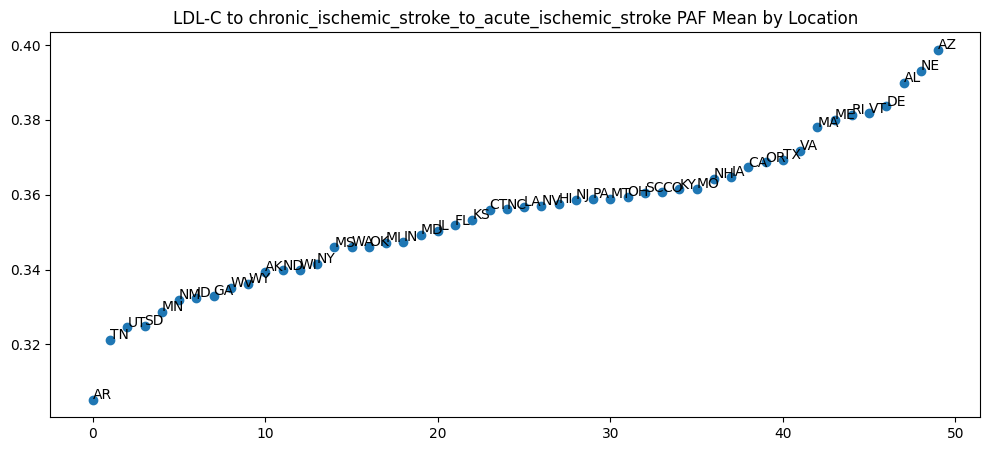

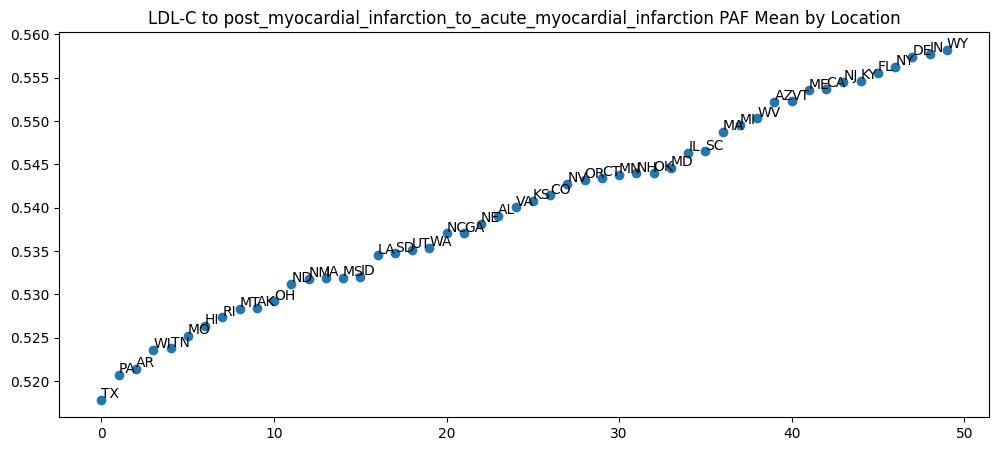

In [20]:
with PdfPages('ldl_pafs_location.pdf') as pdf:
    for cause in ldl_paf.affected_entity.unique():
        plt.figure(figsize=(12,5))
        subdata = ldl_paf.loc[(ldl_paf.affected_entity == cause)].sort_values('mean')
        plt.scatter(range(50), subdata['mean'])
        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
        plt.title(f'LDL-C to {cause} PAF Mean by Location')
        pdf.savefig(bbox_inches='tight')

## Age group over 80 from GBD data

ID is 21 for 80+ and 157 for 25+ 
Going to find the ratio of 80+ to 25+ with the hypothesis that if there are a higher percent of old people, it will affect death rates vs DALY rates

In [32]:
US_pop_25_plus = get_population(age_group_id=[157], 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)

In [33]:
US_pop_25_plus = US_pop_25_plus.rename(columns={'population' : 'pop_25_plus'})
US_pop_25_plus = US_pop_25_plus[['location_id','pop_25_plus']]
US_pop_25_plus.head()

,location_id,pop_25_plus
0,102,2.260218e+08
1,523,3.425549e+06
2,524,4.848432e+05
3,525,4.812495e+06
4,526,2.020596e+06


In [34]:
US_pop_80_plus = get_population(age_group_id=[21], 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)

In [35]:
US_pop_80_plus = US_pop_80_plus.rename(columns={'population' : 'pop_80_plus'})
US_pop_80_plus = US_pop_80_plus[['location_id','pop_80_plus']]
US_pop_80_plus.head()

,location_id,pop_80_plus
0,102,1.248899e+07
1,523,1.868404e+05
2,524,1.467853e+04
3,525,2.750136e+05
4,526,1.167061e+05


In [36]:
US_pop_ratio = US_pop_25_plus.merge(US_pop_80_plus, on = ['location_id']).merge(location_map, on = ['location_id'])
US_pop_ratio['pop_ratio'] = US_pop_ratio['pop_80_plus'] / US_pop_ratio['pop_25_plus']

In [37]:
US_pop_ratio

,location_id,pop_25_plus,pop_80_plus,location_name,abbreviation,pop_ratio
0,102,2.260218e+08,1.248899e+07,US,US,0.055256
1,523,3.425549e+06,1.868404e+05,Alabama,AL,0.054543
2,524,4.848432e+05,1.467853e+04,Alaska,AK,0.030275
3,525,4.812495e+06,2.750136e+05,Arizona,AZ,0.057146
...,...,...,...,...,...,...
48,570,5.265596e+06,2.619228e+05,Washington,WA,0.049742
49,571,1.283409e+06,8.297888e+04,West Virginia,WV,0.064655
50,572,4.056749e+06,2.442828e+05,Wisconsin,WI,0.060216
51,573,3.913808e+05,2.094687e+04,Wyoming,WY,0.053520


Text(0.5, 1.0, 'Ratio of 80+ population to 25+ population by Location')

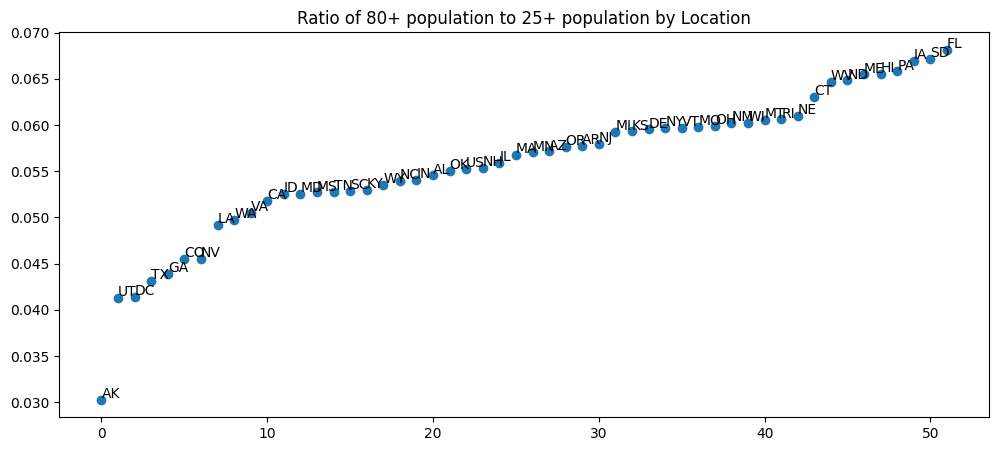

In [38]:
plt.figure(figsize=(12,5))
subdata = US_pop_ratio.sort_values('pop_ratio')
plt.scatter(range(52), subdata['pop_ratio'])
for i in range(52):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['pop_ratio'].iloc[i] + 0.0002))
plt.title('Ratio of 80+ population to 25+ population by Location')

## Including some incidence rates to see if that pops

In [39]:
hf_inc = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
hf_inc.head()

,year_start,mean,location_name,abbreviation,measure
0,2019,0.017127,Washington,WA,incidence_rate
0,2019,0.015524,Alaska,AK,incidence_rate
0,2019,0.015678,Hawaii,HI,incidence_rate
0,2019,0.017950,Colorado,CO,incidence_rate
0,2019,0.019788,Nevada,NV,incidence_rate


Text(0.5, 1.0, 'Heart Failure Residual Incidence Rate by Location')

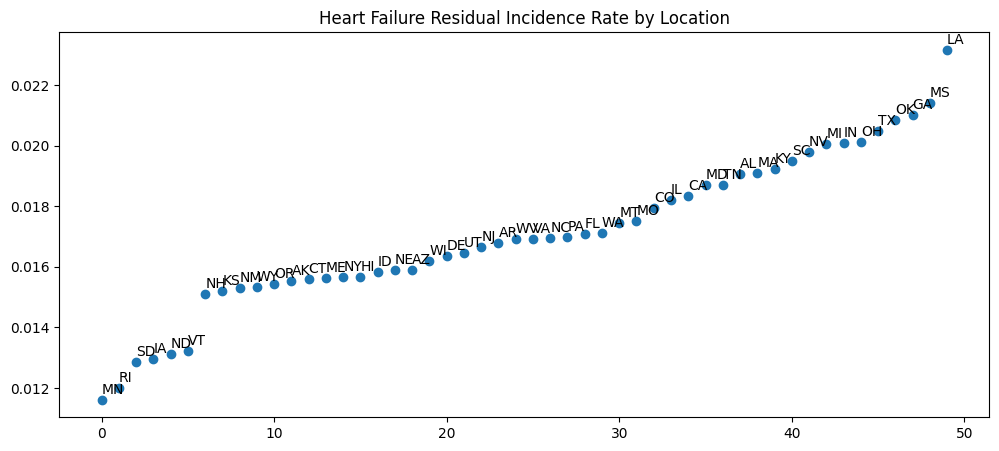

In [40]:
plt.figure(figsize=(12,5))
subdata = hf_inc.sort_values('mean')#.loc[(sbp_std.sex == sex) & (sbp_std.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.0002))
plt.title(f'Heart Failure Residual Incidence Rate by Location')

In [13]:
mi_inc = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
mi_inc.head()

,year_start,mean,2.5%,97.5%,location_name,abbreviation,measure
0,2019,0.009815,0.008617,0.011393,Washington,WA,incidence_rate
0,2019,0.009367,0.007669,0.011666,Alaska,AK,incidence_rate
0,2019,0.010522,0.008833,0.012916,Hawaii,HI,incidence_rate
0,2019,0.009416,0.007884,0.011601,Colorado,CO,incidence_rate
0,2019,0.011009,0.009315,0.012811,Nevada,NV,incidence_rate


Text(0.5, 1.0, 'Acute Myocardial Infarction Incidence Rate by Location')

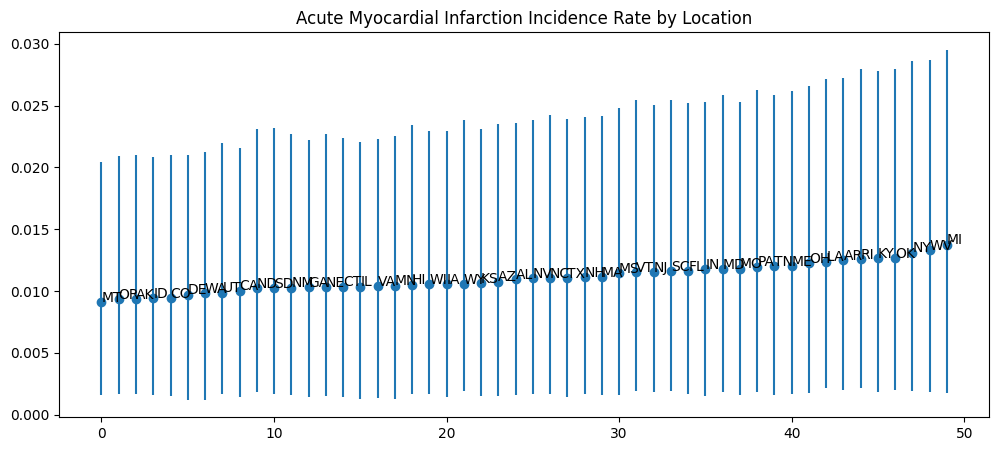

In [14]:
plt.figure(figsize=(12,5))
subdata = mi_inc.sort_values('mean')#.loc[(sbp_std.sex == sex) & (sbp_std.age_start == age)]
#plt.scatter(range(50), subdata['mean'])

y_error = [subdata['2.5%'], subdata['97.5%']]
plt.errorbar(range(50), subdata['mean'], yerr=y_error, fmt='o') 

for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.00002))
plt.title(f'Acute Myocardial Infarction Incidence Rate by Location')

In [49]:
stroke_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
stroke_inc.head()

,year_start,mean,location_name,abbreviation,measure
0,2019,0.003412,Washington,WA,incidence_rate
0,2019,0.003302,Alaska,AK,incidence_rate
0,2019,0.003145,Hawaii,HI,incidence_rate
0,2019,0.003163,Colorado,CO,incidence_rate
0,2019,0.003409,Nevada,NV,incidence_rate


Text(0.5, 1.0, 'Acute Stroke Incidence Rate by Location')

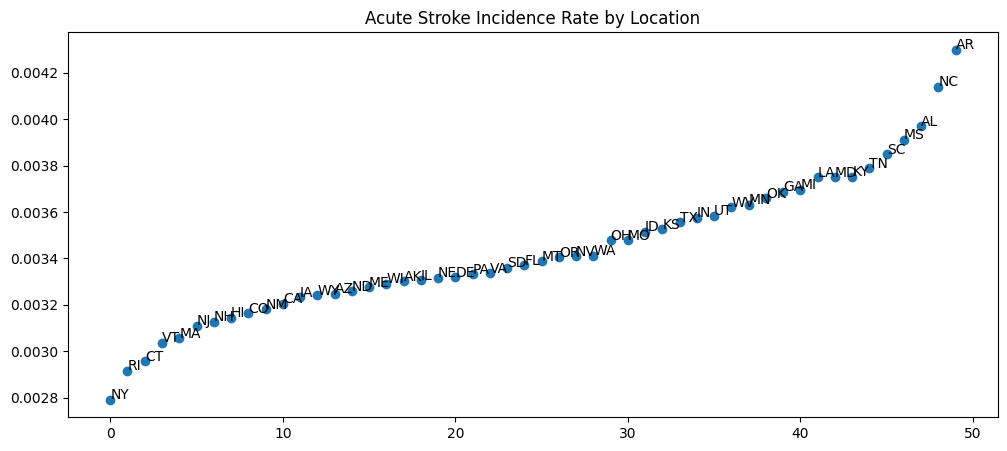

In [51]:
plt.figure(figsize=(12,5))
subdata = stroke_inc.sort_values('mean')#.loc[(sbp_std.sex == sex) & (sbp_std.age_start == age)]
plt.scatter(range(50), subdata['mean'])
for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i, subdata['mean'].iloc[i] + 0.000002))
plt.title(f'Acute Stroke Incidence Rate by Location')